In [ ]:
import numpy as np
import pandas as pd
import ast
from itertools import combinations

from rouge_score import rouge_scorer

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Importation des données

# Dictionnaire de renommage commun
rename_cols = {
    "Qui": "who",
    "Quoi": "what",
    "Où": "where",
    "Quand": "when",
    "Pourquoi": "why",
    "Comment": "how"
}

# Liste des fichiers et noms de variables correspondants
file_map = {
    "fr5w1h_df": "giveme5W1H_answers.csv",
    "gpt_df": "gpt_answers_full.csv",
    "ams_df": "AM_S_answers_full.csv",
    "mkf_df": "MKF_answers_full.csv",
    "tt_df": "TT_answers_full.csv",
    "zl_df": "ZL_answers_full.csv"
}

# Chargement + renommage automatique
locals().update({
    var: pd.read_csv(file).rename(columns=rename_cols) 
    for var, file in file_map.items()
})


In [8]:
# Fonction utilitaire pour extraire les scores ROUGE

def get_ROUGE(extract_1, extract_2):
    # ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(extract_1, extract_2)
    return {"ROUGE-1":rouge_scores['rouge1'].fmeasure, "ROUGE-2":rouge_scores['rouge2'].fmeasure, "ROUGE-L":rouge_scores['rougeL'].fmeasure}

In [12]:
# Calcul des scores ROUGE pour chaque binôme d'annotateurs
annotator_dfs = {
    "Annotator_1": ams_df,
    "Annotator_2": mkf_df,
    "Annotator_3": tt_df,
    "Annotator_4": zl_df,
    "GPT": gpt_df,
    "FR_5W1H": fr5w1h_df,
}

question_types = ['who', 'what', 'where', 'when', 'why', 'how']

def compute_rouge_means(df1, df2, name1, name2):
    results = []
    questions = ["who", "what", "where", "when", "why", "how"]

    # Préfixer les colonnes
    df1 = df1.add_suffix("_1")
    df2 = df2.add_suffix("_2")
    
    merged = pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True)], axis=1)

    for q in questions:
        rouge_1_list = []
        rouge_2_list = []
        rouge_l_list = []

        for _, row in merged.iterrows():
            ref = row.get(f"{q}_1")
            hyp = row.get(f"{q}_2")

            # Cas 1 : les deux sont vides ou NaN → score parfait (1.0)
            if (pd.isna(ref) or str(ref).strip() == "") and (pd.isna(hyp) or str(hyp).strip() == ""):
                rouge_1_list.append(1.0)
                rouge_2_list.append(1.0)
                rouge_l_list.append(1.0)

            # Cas 2 : un seul est vide ou NaN → score nul (0.0)
            elif (pd.isna(ref) or str(ref).strip() == "") or (pd.isna(hyp) or str(hyp).strip() == ""):
                rouge_1_list.append(0.0)
                rouge_2_list.append(0.0)
                rouge_l_list.append(0.0)

            # Cas 3 : les deux sont présents → score ROUGE normal
            else:
                scores = get_ROUGE(str(ref), str(hyp))
                rouge_1_list.append(scores["ROUGE-1"])
                rouge_2_list.append(scores["ROUGE-2"])
                rouge_l_list.append(scores["ROUGE-L"])

        # Moyennes (toujours calculées maintenant)
        result = {
            "Annotator_A": name1,
            "Annotator_B": name2,
            "Question": q,
            "ROUGE-1": sum(rouge_1_list) / len(rouge_1_list),
            "ROUGE-2": sum(rouge_2_list) / len(rouge_2_list),
            "ROUGE-L": sum(rouge_l_list) / len(rouge_l_list),
        }
        results.append(result)

    return results

# Étape principale : combinaisons des binômes
all_results = []

for (name1, df1), (name2, df2) in combinations(annotator_dfs.items(), 2):
    pair_results = compute_rouge_means(df1, df2, name1, name2)
    all_results.extend(pair_results)

# Résultat final
results_df = pd.DataFrame(all_results)
results_df.head()

,Annotator_A,Annotator_B,Question,ROUGE-1,ROUGE-2,ROUGE-L
0,Annotator_1,Annotator_2,who,0.156915,0.103670,0.153657
1,Annotator_1,Annotator_2,what,0.145151,0.058199,0.122134
2,Annotator_1,Annotator_2,where,0.186301,0.145834,0.186301
3,Annotator_1,Annotator_2,when,0.121009,0.021008,0.120627
4,Annotator_1,Annotator_2,why,0.089010,0.025931,0.073162


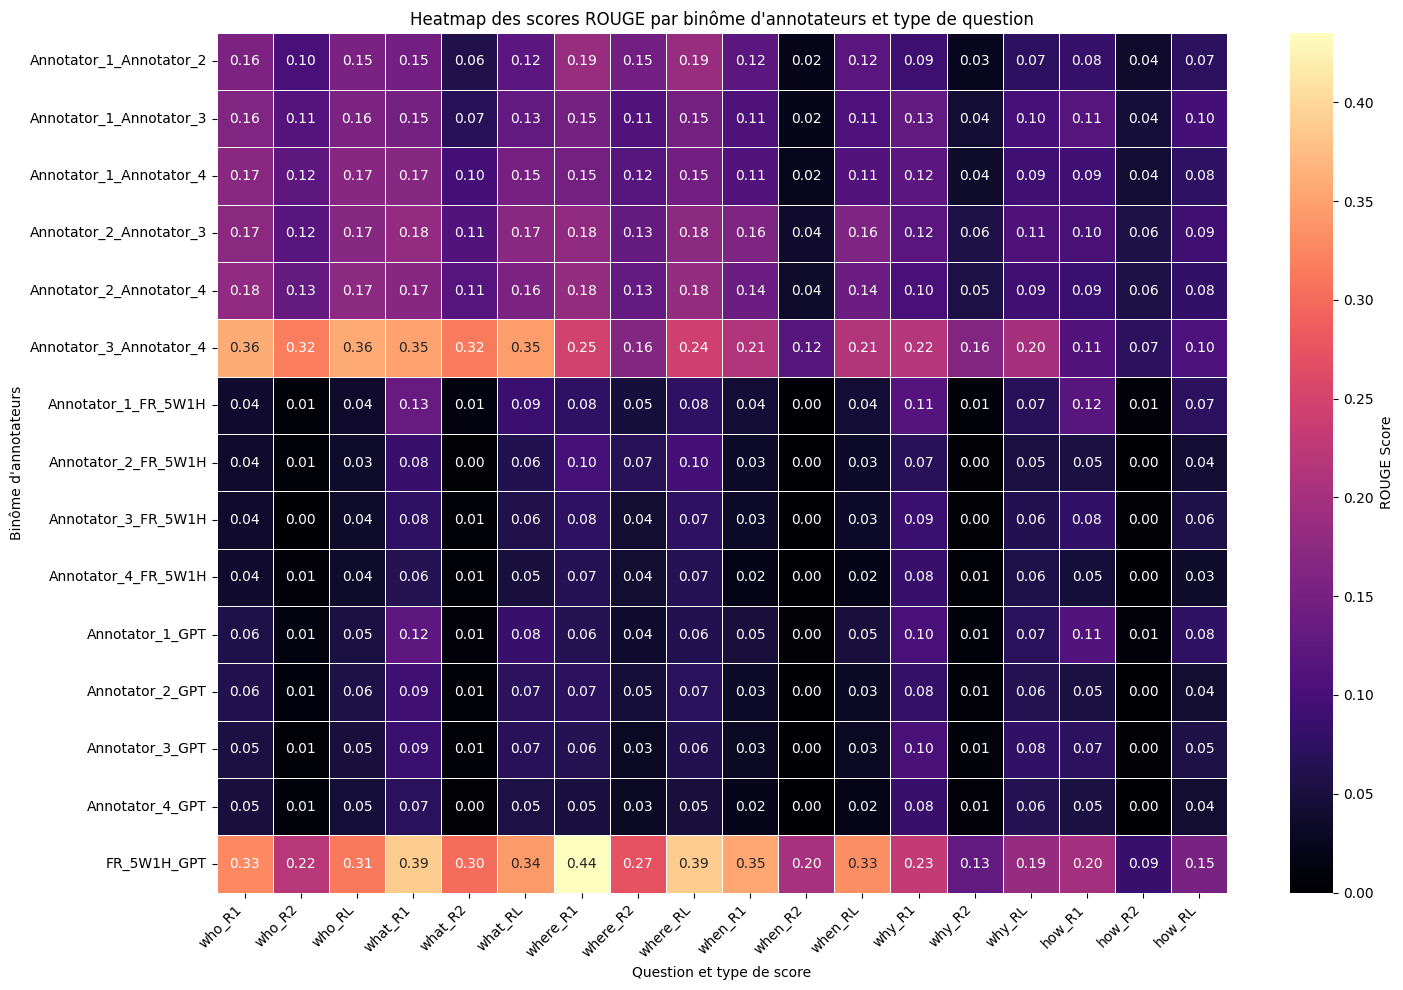

In [ ]:
# Réorganisation du dataframe et affichage des résultats

# Colonnes Annotator_Pair triées alphabétiquement
results_df["Annotator_Pair"] = results_df.apply(
    lambda r: "_".join(sorted([r["Annotator_A"], r["Annotator_B"]])),
    axis=1
)
melted = pd.melt(
    results_df,
    id_vars=["Annotator_Pair", "Question"],
    value_vars=["ROUGE-1", "ROUGE-2", "ROUGE-L"],
    var_name="ROUGE_Type",
    value_name="Score"
)

# Colonne combinée "question_ROUGE"
melted["Question_ROUGE"] = melted["Question"] + "_" + melted["ROUGE_Type"].str.replace("ROUGE-", "R")

heatmap_df = melted.pivot(
    index="Annotator_Pair",
    columns="Question_ROUGE",
    values="Score"
)

# Réindexation lignes (ordre des binômes)
row_order = [
    "Annotator_1_Annotator_2",
    "Annotator_1_Annotator_3",
    "Annotator_1_Annotator_4",
    "Annotator_2_Annotator_3",
    "Annotator_2_Annotator_4",
    "Annotator_3_Annotator_4",
    "Annotator_1_FR_5W1H",
    "Annotator_2_FR_5W1H",
    "Annotator_3_FR_5W1H",
    "Annotator_4_FR_5W1H",
    "Annotator_1_GPT",
    "Annotator_2_GPT",
    "Annotator_3_GPT",
    "Annotator_4_GPT",
    "FR_5W1H_GPT"
]

# Réindexation colonnes (ordre who, what, where, when, why, how pour chaque ROUGE)
questions = ['who', 'what', 'where', 'when', 'why', 'how']
rouge_types = ['R1', 'R2', 'RL']
col_order = [f"{q}_{r}" for q in questions for r in rouge_types]

# Réindexation complète
heatmap_df = heatmap_df.reindex(index=row_order, columns=col_order)

# Affichage
plt.figure(figsize=(15, 10))
sns.heatmap(
    heatmap_df,
    cmap="magma",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'ROUGE Score'}
)
plt.title("Heatmap des scores ROUGE par binôme d'annotateurs et type de question")
plt.ylabel("Binôme d'annotateurs")
plt.xlabel("Question et type de score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

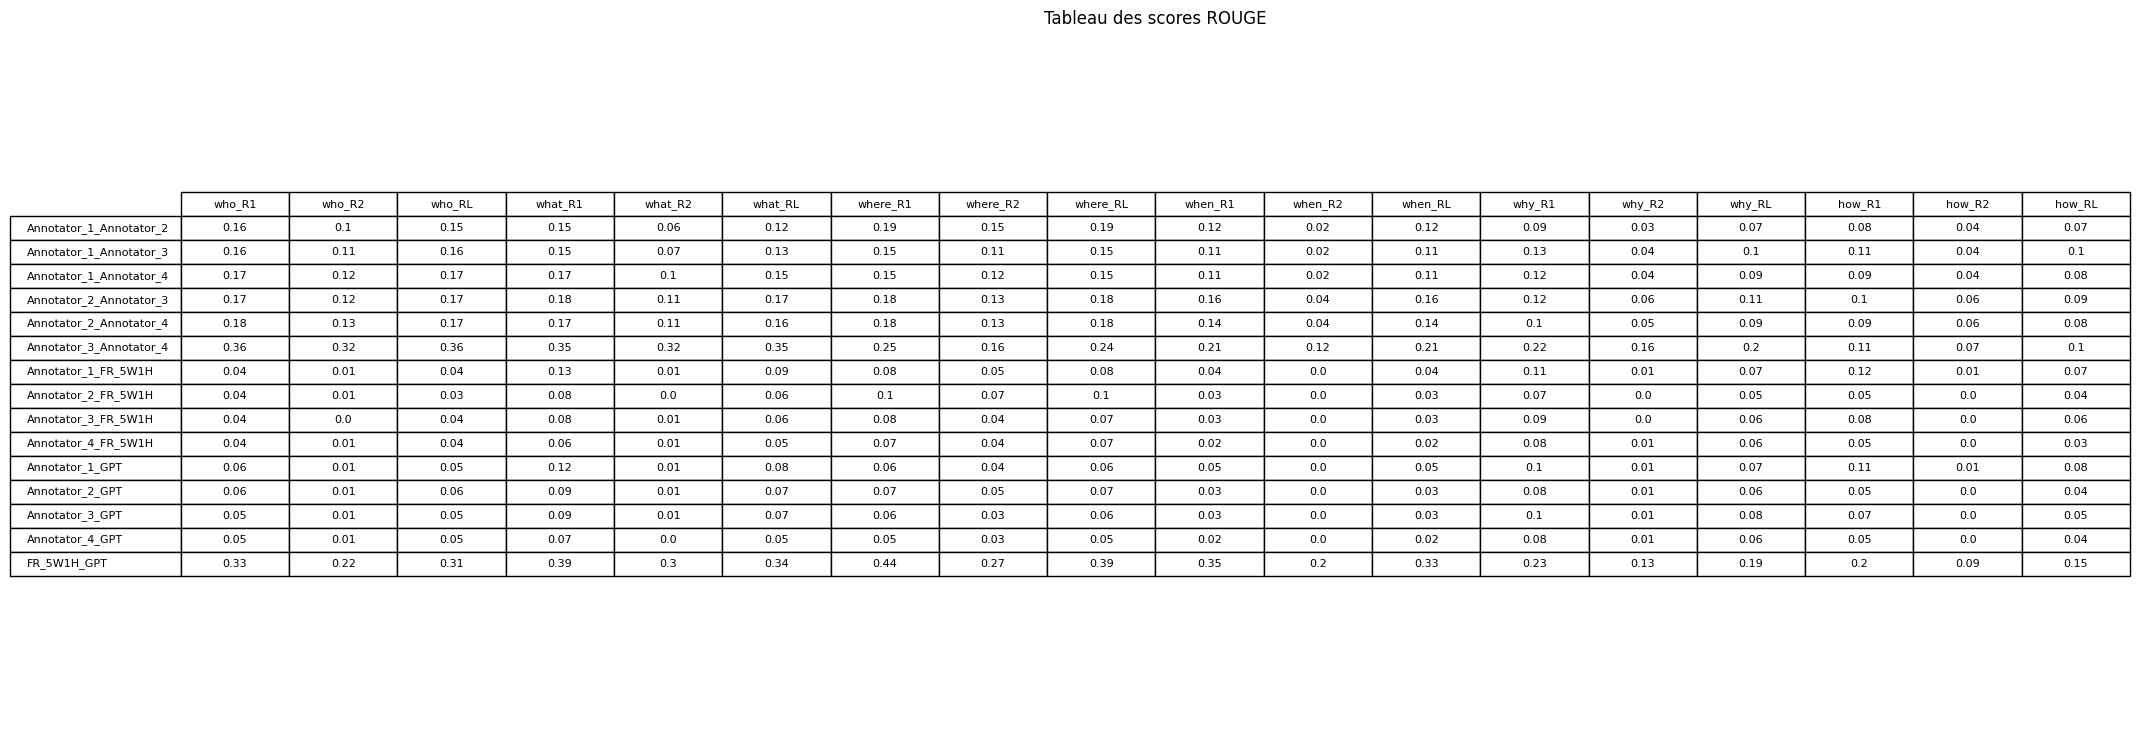

In [16]:
# Affichage sous forme de tableau simple

# Création de la figure
fig, ax = plt.subplots(figsize=(len(heatmap_df.columns) * 1.2, len(heatmap_df.index) * 0.5))

# Suppression des axes
ax.axis('off')

# Création du tableau
table = ax.table(
    cellText=heatmap_df.round(2).values,
    rowLabels=heatmap_df.index.tolist(),
    colLabels=heatmap_df.columns.tolist(),
    loc='center',
    cellLoc='center'
)

# Mise en forme compacte
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.2) 

# Affichage
plt.title("Tableau des scores ROUGE", fontsize=12, pad=10)
plt.tight_layout()
plt.show()

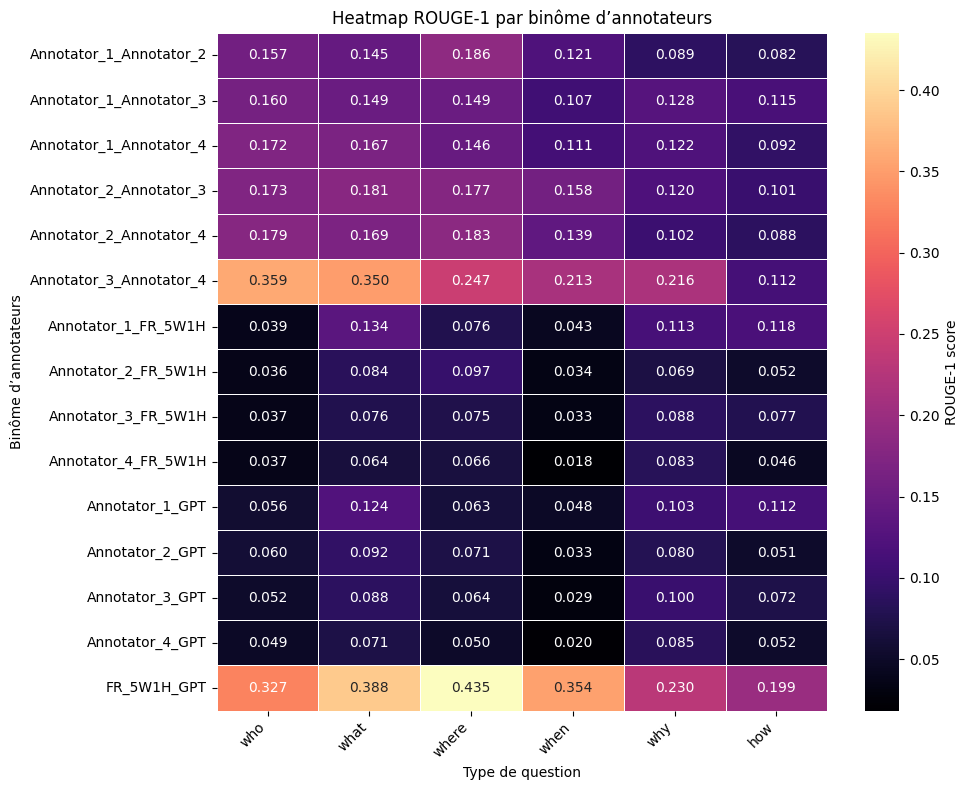

In [17]:
# Affichage d'un seul des trois scores ROUGE (ici ROUGE-1)

# Identifiant du binôme
results_df["Annotator_Pair"] = results_df.apply(
    lambda r: "_".join(sorted([r["Annotator_A"], r["Annotator_B"]])),
    axis=1
)

# On ne garde que ROUGE-1
rouge1_df = results_df[["Annotator_Pair", "Question", "ROUGE-1"]]
heatmap_df = rouge1_df.pivot(index="Annotator_Pair",
                             columns="Question",
                             values="ROUGE-1")

# Ordre voulu
row_order = [
    "Annotator_1_Annotator_2",
    "Annotator_1_Annotator_3",
    "Annotator_1_Annotator_4",
    "Annotator_2_Annotator_3",
    "Annotator_2_Annotator_4",
    "Annotator_3_Annotator_4",
    "Annotator_1_FR_5W1H",
    "Annotator_2_FR_5W1H",
    "Annotator_3_FR_5W1H",
    "Annotator_4_FR_5W1H",
    "Annotator_1_GPT",
    "Annotator_2_GPT",
    "Annotator_3_GPT",
    "Annotator_4_GPT",
    "FR_5W1H_GPT"
]
col_order = ['who', 'what', 'where', 'when', 'why', 'how']

# Ré-indexation lignes + colonnes
heatmap_df = heatmap_df.reindex(index=row_order, columns=col_order)

# Affichage
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_df,
    cmap="magma",
    annot=True,
    fmt=".3f",
    linewidths=0.5,
    cbar_kws={'label': 'ROUGE-1 score'}
)
plt.title("Heatmap ROUGE-1 par binôme d’annotateurs")
plt.ylabel("Binôme d’annotateurs")
plt.xlabel("Type de question")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [18]:
# Mélange de tableau et heatmap

styled_table = results_df.round(3).style.set_properties(**{
    'text-align': 'center'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'center')]
}]).background_gradient(cmap='magma', subset=["ROUGE-1", "ROUGE-2", "ROUGE-L"])

styled_table

,Annotator_A,Annotator_B,Question,ROUGE-1,ROUGE-2,ROUGE-L,Annotator_Pair
0,Annotator_1,Annotator_2,who,0.157000,0.104000,0.154000,Annotator_1_Annotator_2
1,Annotator_1,Annotator_2,what,0.145000,0.058000,0.122000,Annotator_1_Annotator_2
2,Annotator_1,Annotator_2,where,0.186000,0.146000,0.186000,Annotator_1_Annotator_2
3,Annotator_1,Annotator_2,when,0.121000,0.021000,0.121000,Annotator_1_Annotator_2
4,Annotator_1,Annotator_2,why,0.089000,0.026000,0.073000,Annotator_1_Annotator_2
5,Annotator_1,Annotator_2,how,0.082000,0.036000,0.071000,Annotator_1_Annotator_2
6,Annotator_1,Annotator_3,who,0.160000,0.112000,0.158000,Annotator_1_Annotator_3
7,Annotator_1,Annotator_3,what,0.149000,0.069000,0.128000,Annotator_1_Annotator_3
8,Annotator_1,Annotator_3,where,0.149000,0.110000,0.148000,Annotator_1_Annotator_3
9,Annotator_1,Annotator_3,when,0.107000,0.020000,0.107000,Annotator_1_Annotator_3
